In [ ]:
import pandas as pd
import networkx as nx
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import random
from scipy import stats
from collections import deque

In [ ]:
"""
for google colab support
"""

from google.colab import drive
import os

gdrive_path='/content/gdrive/MyDrive/BA/SI-ModelsPandemic'

# This will mount your google drive under 'MyDrive'
drive.mount('/content/gdrive', force_remount=True)
# In order to access the files in this notebook we have to navigate to the correct folder
os.chdir(gdrive_path)
# Check manually if all files are present
print(sorted(os.listdir()))

Mounted at /content/gdrive
['SI-Pandemic.ipynb', 'SIR_Model_Simulation.csv', 'SIR_Model_Simulation_100_Times.csv', 'SI_Model_Simulation.csv', 'SI_Model_Simulation_100_Times.csv']


In [ ]:
# Load CSV files
current_directory = os.getcwd()

# Navigate one folder up
parent_directory = os.path.dirname(current_directory)

# Construct the path to the "CSV-Files" folder
csv_files_folder = os.path.join(parent_directory, "CSV-Files ")

file_path = os.path.join(csv_files_folder, "cities.csv")

cities_df = pd.read_csv(file_path, index_col='City')

file_path = os.path.join(csv_files_folder, "edges.csv")

edges_df = pd.read_csv(file_path)

file_path = os.path.join(csv_files_folder, "node_positions.csv")

positions_df = pd.read_csv(file_path, index_col='City')

In [ ]:
print(cities_df.columns)


Index(['Color'], dtype='object')


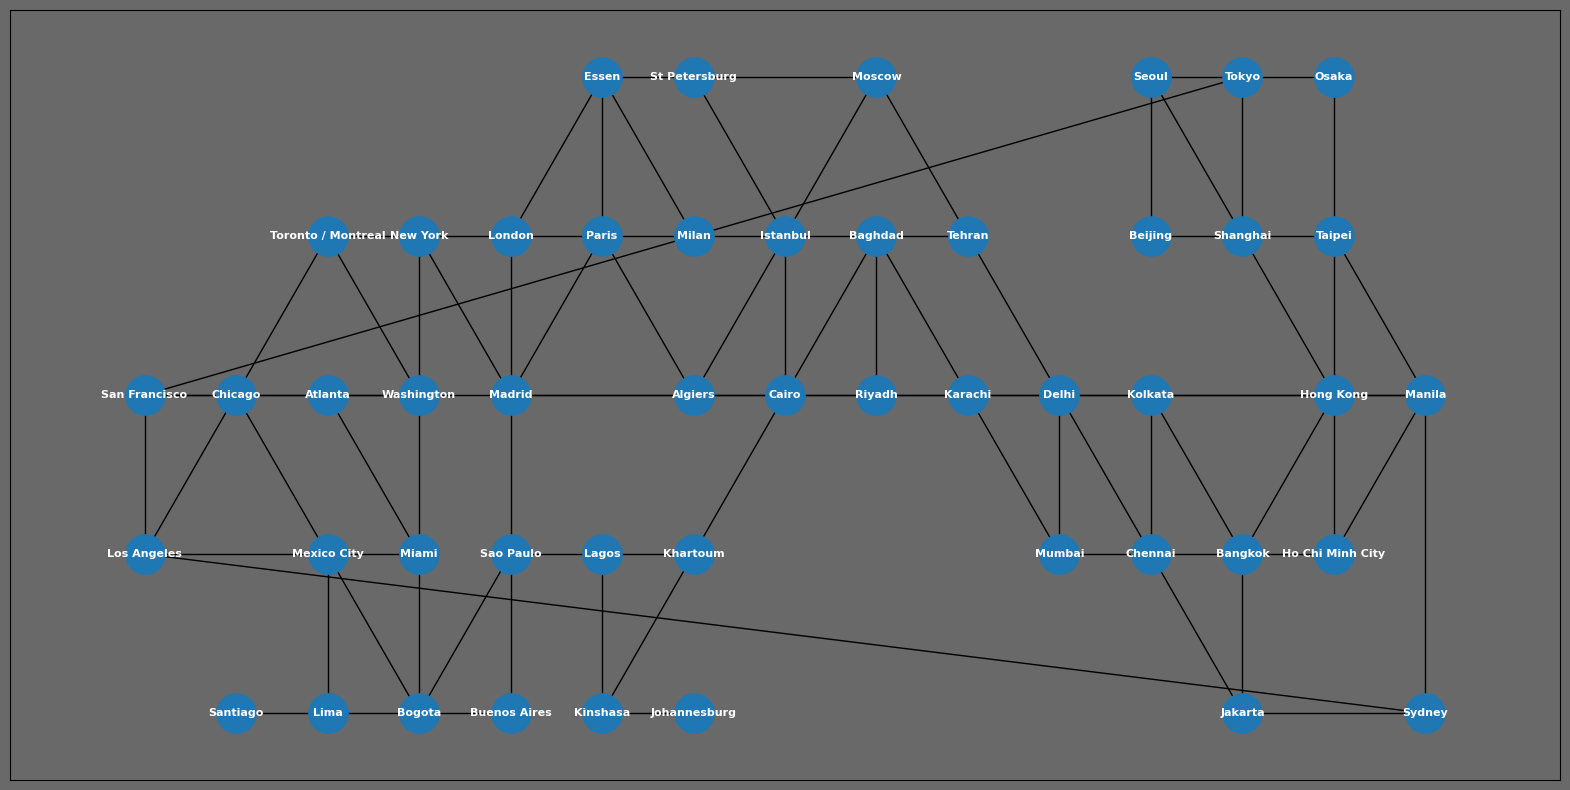

In [ ]:
# Create an empty graph
Graph_gameboard = nx.Graph()

# Add nodes with attributes
for city in cities_df.index:
    Graph_gameboard.add_node(city)

# Add edges from DataFrame
Graph_gameboard.add_edges_from(edges_df.values)

# Define node positions
node_positions = positions_df.apply(tuple, axis=1).to_dict()

fig, ax = plt.subplots(figsize=(20, 10))

# Draw the nodes
nx.draw_networkx_nodes(Graph_gameboard, pos=node_positions, node_size=800)

# Draw the edges
nx.draw_networkx_edges(Graph_gameboard, pos=node_positions)

for node, (x, y) in node_positions.items():
    plt.text(x, y, node, fontsize=8, ha='center', va='center', color='white', weight='bold')

    ax.set_facecolor('#696969')
    fig.set_facecolor('#696969')

plt.show()

# **SI Model**


In [ ]:
def initialize_si_model(graph, initial_infected_fraction):
    num_nodes = graph.number_of_nodes()
    num_infected = int(initial_infected_fraction * num_nodes)

    infected_nodes = random.sample(graph.nodes, num_infected)

    si_model = {"graph": graph, "infected_nodes": set(infected_nodes)}

    return si_model

In [ ]:
def plot_graph(si_model, title, node_positions):
    graph = si_model["graph"]
    infected_nodes = si_model["infected_nodes"]

    fig, ax = plt.subplots(figsize=(20, 10))

    # Draw the nodes with colors based on infection status
    nx.draw_networkx_nodes(graph, pos=node_positions, node_color=['red' if node in infected_nodes else 'blue' for node in graph.nodes], node_size=800)

    # Draw the edges
    nx.draw_networkx_edges(graph, pos=node_positions)

    # Add labels manually with white color
    for node, (x, y) in node_positions.items():
        plt.text(x, y, node, fontsize=8, ha='center', va='center', color='white', weight='bold')

    ax.set_facecolor('#696969')
    fig.set_facecolor('#696969')
    plt.title(title)
    plt.show()


In [ ]:
def run_si_model(si_model):
    graph = si_model["graph"]
    infected_nodes = si_model["infected_nodes"]

    statistics = []
    step = 0
    #plot_graph(si_model, "SI-Model on Pandemic graph Step 0", node_positions)
    # Continue running until all nodes are infected
    while len(infected_nodes) < graph.number_of_nodes():
        new_infected_nodes = set()

        for node in infected_nodes:
            neighbors = set(graph.neighbors(node))
            new_infected_nodes.update(neighbors - infected_nodes)

        infected_nodes.update(new_infected_nodes)

        statistics.append({
            'timestep': step,
            'susceptible_nodes': len([node for node in graph.nodes if node not in infected_nodes]),
            'infected_nodes': len(infected_nodes)
        })

        step += 1
        #plot_graph(si_model, f'SI-Model on Pandemic graph Step {step}', node_positions)


    return statistics


<ipython-input-6-527af0bc6c6c>:5: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  infected_nodes = random.sample(graph.nodes, num_infected)


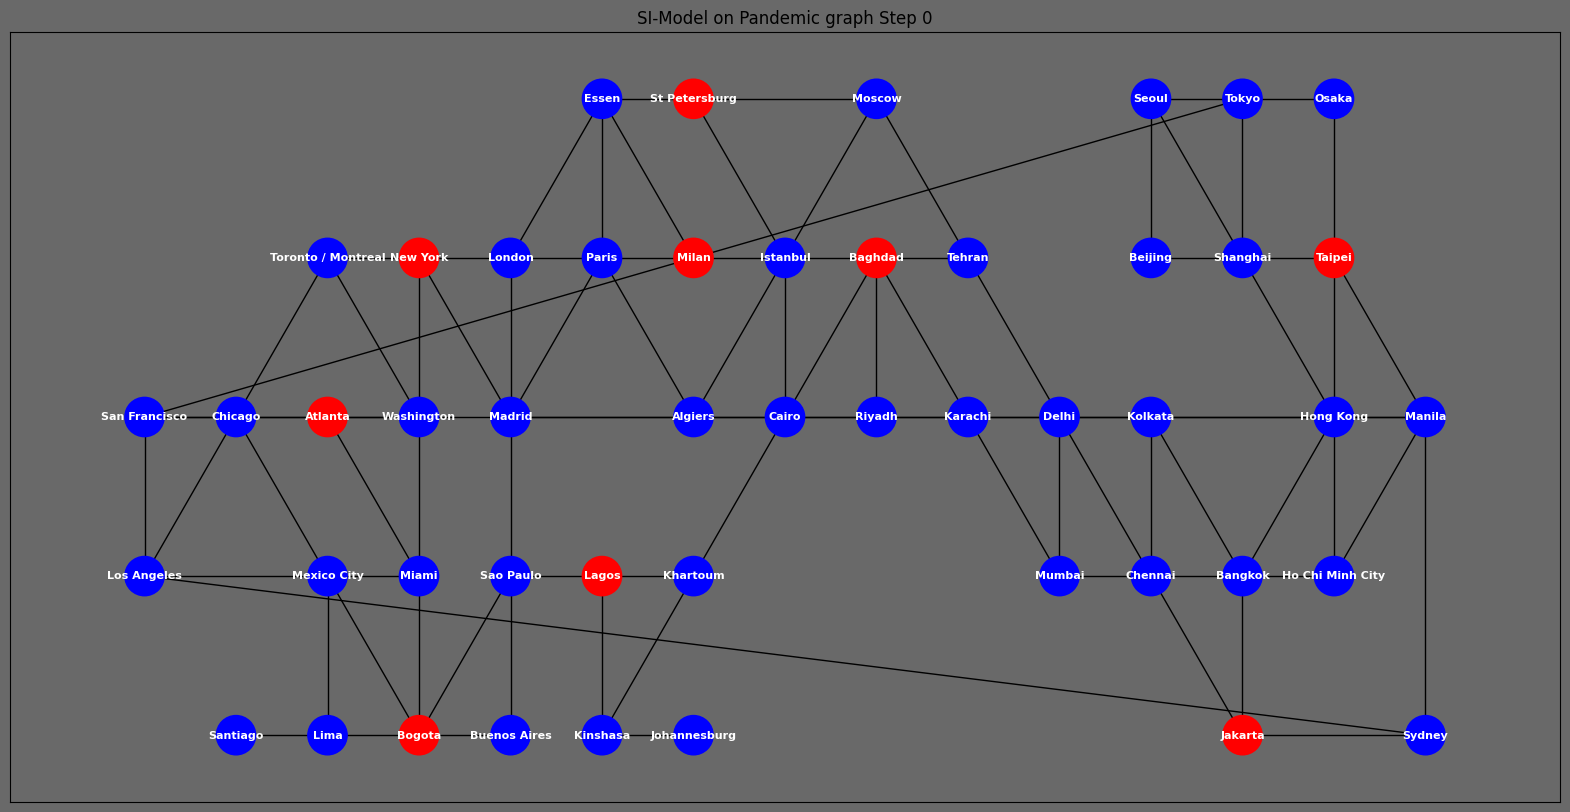

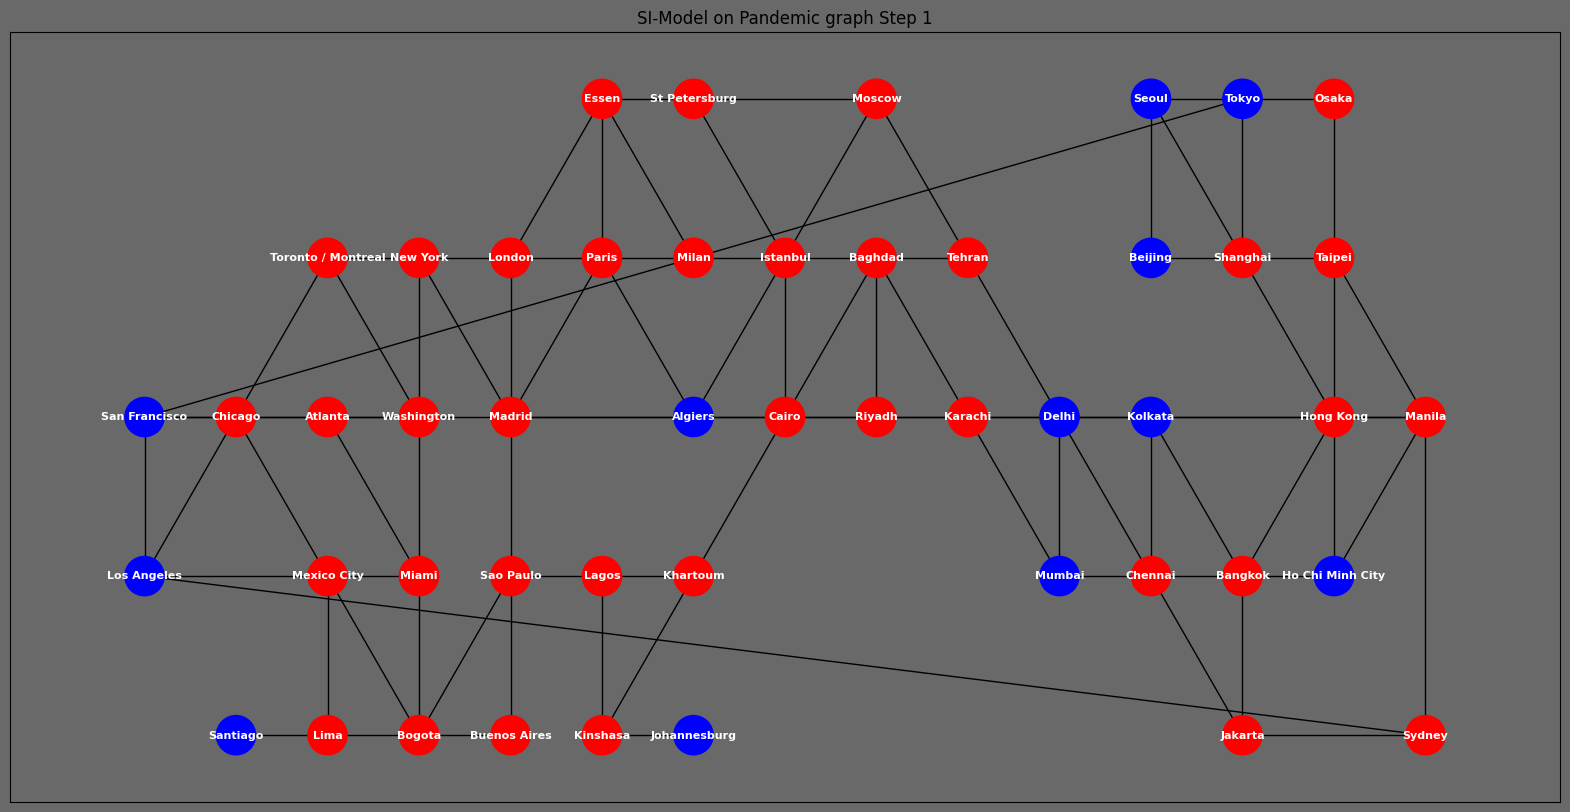

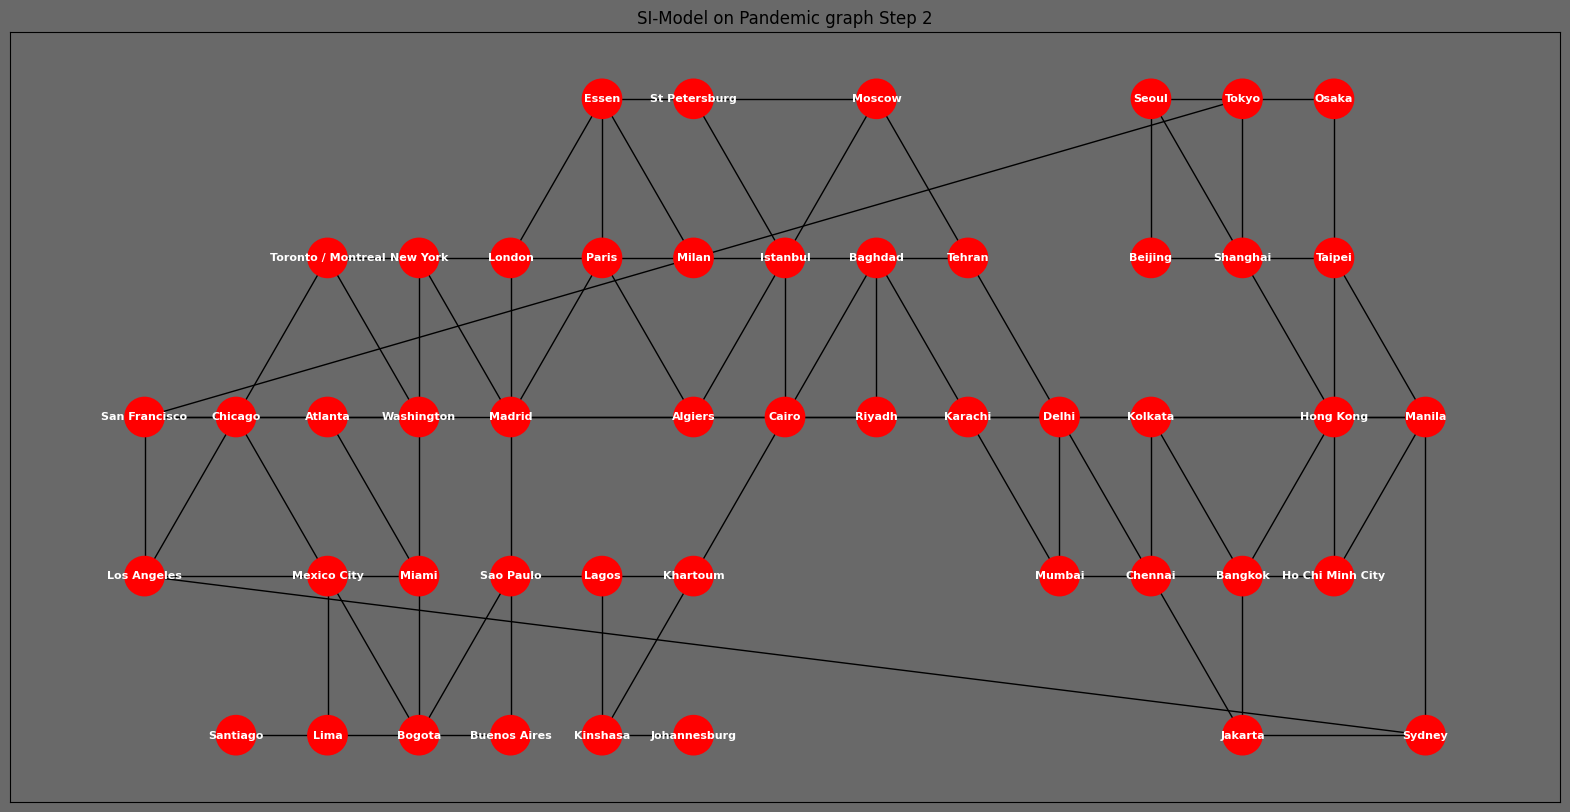

In [ ]:
if __name__ == "__main__":
    # Set the initial fraction of infected nodes
    initial_infected_fraction = 0.1875

    # Initialize SI model
    si_model = initialize_si_model(Graph_gameboard, initial_infected_fraction)

    # Run the SI model until all nodes are infected
    statistics = run_si_model(si_model)

    # Convert statistics to a DataFrame
    df = pd.DataFrame(statistics)

    # Save DataFrame to a CSV file
    df.to_csv('SI_Model_Simulation.csv', index=False)


In [ ]:
if __name__ == "__main__":
    # Set the initial fraction of infected nodes
    # 9 nodes out of 48
    initial_infected_fraction = 0.1875

    all_statistics = []

    # Run the SI model simulation 100 times
    for run in range(1, 101):
        # Initialize SI model
        si_model = initialize_si_model(Graph_gameboard, initial_infected_fraction)

        # Run the SI model until all nodes are infected
        statistics = run_si_model(si_model)

        # Add the run number to each record and add it to all_statistics
        for record in statistics:
            record['run'] = run
            all_statistics.append(record)

    # Convert all_statistics to a DataFrame
    df = pd.DataFrame(all_statistics)

    # Save DataFrame to a CSV file
    df.to_csv('SI_Model_Simulation_100_Times.csv', index=False)


<ipython-input-6-527af0bc6c6c>:5: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  infected_nodes = random.sample(graph.nodes, num_infected)


In [ ]:
df = pd.read_csv('SI_Model_Simulation_100_Times.csv')

# Group by 'run' and find the maximum 'timestep' for each group
max_timesteps = df.groupby('run')['timestep'].max()

# Calculate the average number of timesteps
avg_timesteps = max_timesteps.mean()

print(f"The average number of timesteps it takes for a run to infect all nodes is {avg_timesteps}")

The average number of timesteps it takes for a run to infect all nodes is 2.41


# **SIR Model**


In [ ]:
def initialize_sir_model(graph, initial_infected_fraction):
    num_nodes = graph.number_of_nodes()
    num_infected = int(initial_infected_fraction * num_nodes)

    infected_nodes = random.sample(graph.nodes, num_infected)
    susceptible_nodes = set(graph.nodes) - set(infected_nodes)
    recovered_nodes = set()

    sir_model = {"graph": graph, "infected_nodes": set(infected_nodes), "susceptible_nodes": set(susceptible_nodes), "recovered_nodes": set(recovered_nodes)}

    return sir_model

def plot_sir_graph(sir_model, title, node_position):
    graph = sir_model["graph"]

    infected_nodes = sir_model["infected_nodes"]
    susceptible_nodes = sir_model["susceptible_nodes"]
    recovered_nodes = sir_model["recovered_nodes"]

    fig, ax = plt.subplots(figsize=(20, 10))

    nx.draw_networkx_nodes(graph, node_position, node_color=['red' if node in infected_nodes else 'green' if node in recovered_nodes else 'blue' for node in graph.nodes], node_size=800)

    nx.draw_networkx_edges(graph, pos=node_positions)

    for node, (x, y) in node_positions.items():
        plt.text(x, y, node, fontsize=8, ha='center', va='center', color='white', weight='bold')

    ax.set_facecolor('#696969')
    fig.set_facecolor('#696969')
    plt.title(title)
    plt.show()

def run_sir_model(sir_model, beta, gamma):
    graph = sir_model["graph"]
    infected_nodes = sir_model["infected_nodes"]
    susceptible_nodes = sir_model["susceptible_nodes"]
    recovered_nodes = sir_model["recovered_nodes"]

    statistics = []
    step = 0

    #plot_sir_graph(sir_model, "SIR-Model on Pandemic graph Step 0", node_positions)

    while len(infected_nodes) != 0:
        new_infected_nodes = set()
        new_recovered_nodes = set()

        # 1 / gamma to have steps till recovery
        for node in infected_nodes:
            if random.random() <= gamma:
                new_recovered_nodes.add(node)
                recovered_nodes.update(new_recovered_nodes)
                continue

            neighbors = set(graph.neighbors(node)) - recovered_nodes
            num_neighbors_to_infect = min(int(beta), len(neighbors))

            neighbors_to_infect = random.sample(neighbors, num_neighbors_to_infect)
            new_infected_nodes.update(neighbors_to_infect)

        infected_nodes.update(new_infected_nodes)
        infected_nodes -= new_recovered_nodes

        statistics.append({
            'timestep': step,
            'susceptible_nodes': len([node for node in graph.nodes if node not in infected_nodes and node not in recovered_nodes]),
            'infected_nodes': len(infected_nodes),
            'recovered_nodes': len(recovered_nodes)
        })

        step += 1
        #plot_sir_graph(sir_model, f'SIR-Model on Pandemic graph Step {step}', node_positions)

    return statistics

In [ ]:
if __name__ == "__main__":
    # Set the initial fraction of infected nodes
    initial_infected_fraction = 0.1875

    # Initialize SIR model
    sir_model = initialize_sir_model(Graph_gameboard, initial_infected_fraction)

    beta = 2.6
    gamma = 0.2
    # Run the SIR model until all nodes are infected
    statistics = sir_model = run_sir_model(sir_model, beta, gamma)

    # Convert statistics to a DataFrame
    df = pd.DataFrame(statistics)

    # Save DataFrame to a CSV file
    df.to_csv('SIR_Model_Simulation.csv', index=False)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
if __name__ == "__main__":

    initial_infected_fraction = 0.1875

    all_statistics = []

    for run in range(1, 101):
        sir_model = initialize_sir_model(Graph_gameboard, initial_infected_fraction)

        beta = 2.6
        gamma = 0.2
        statistics = sir_model = run_sir_model(sir_model, beta, gamma)

        for record in statistics:
            record['run'] = run
            all_statistics.append(record)

    df = pd.DataFrame(all_statistics)
    df.to_csv('SIR_Model_Simulation_100_Times.csv', index=False)

<ipython-input-29-40dcc0daa351>:5: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  infected_nodes = random.sample(graph.nodes, num_infected)
<ipython-input-29-40dcc0daa351>:59: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  neighbors_to_infect = random.sample(neighbors, num_neighbors_to_infect)


In [ ]:
df = pd.read_csv('SIR_Model_Simulation_100_Times.csv')

# Group by 'run' and find the maximum 'timestep' for each group
max_timesteps = df.groupby('run')['timestep'].max()

# Calculate the average number of timesteps
avg_timesteps = max_timesteps.mean()





print(f"The average number of timesteps it takes for a run to infect all nodes is {avg_timesteps}")

The average number of timesteps it takes for a run to infect all nodes is 21.18


# **SIS Model**


In [ ]:
def initialize_sis_model(graph, initial_infected_fraction):
    num_nodes = graph.number_of_nodes()
    num_infected = int(initial_infected_fraction * num_nodes)

    infected_nodes = random.sample(graph.nodes, num_infected)
    susceptible_nodes = set(graph.nodes) - set(infected_nodes)

    sis_model = {"graph": graph, "infected_nodes": set(infected_nodes), "susceptible_nodes": set(susceptible_nodes)}

    return sis_model

def plot_sis_graph(sis_model, title, node_position):
    graph = sis_model["graph"]

    infected_nodes = sis_model["infected_nodes"]
    susceptible_nodes = sis_model["susceptible_nodes"]

    fig, ax = plt.subplots(figsize=(20, 10))

    nx.draw_networkx_nodes(graph, node_position, node_color=['red' if node in infected_nodes else 'blue' for node in graph.nodes], node_size=800)

    nx.draw_networkx_edges(graph, pos=node_positions)

    for node, (x, y) in node_positions.items():
        plt.text(x, y, node, fontsize=8, ha='center', va='center', color='white', weight='bold')

    ax.set_facecolor('#696969')
    fig.set_facecolor('#696969')
    plt.title(title)
    plt.show()

def run_sis_model(sis_model, num_steps, beta, gamma):
    graph = sis_model["graph"]
    infected_nodes = sis_model["infected_nodes"]
    susceptible_nodes = sis_model["susceptible_nodes"]

    statistics = []

    #plot_sis_graph(sis_model, "SIS-Model on Pandemic graph Step 0", node_positions)

    for step in range(num_steps):
        new_infected_nodes = set()
        new_susceptible_nodes = set()

        for node in infected_nodes:
            if random.random() <= gamma:
                new_susceptible_nodes.add(node)
                susceptible_nodes.update(new_susceptible_nodes)
                continue

            neighbors = set(graph.neighbors(node))
            num_neighbors_to_infect = min(int(beta), len(neighbors))

            neighbors_to_infect = random.sample(neighbors, num_neighbors_to_infect)
            new_infected_nodes.update(neighbors_to_infect)

        infected_nodes.update(new_infected_nodes)
        infected_nodes -= new_susceptible_nodes

        statistics.append({
            'timestep': step,
            'susceptible_nodes': len([node for node in graph.nodes if node not in infected_nodes]),
            'infected_nodes': len(infected_nodes),
        })

        step += 1
        #plot_sis_graph(sis_model, f'SIS-Model on Pandemic graph Step {step}', node_positions)

    return statistics

In [ ]:
if __name__ == "__main__":
    # Set the initial fraction of infected nodes
    initial_infected_fraction = 0.1875

    # Initialize SIR model
    sis_model = initialize_sis_model(Graph_gameboard, initial_infected_fraction)

    beta = 2.6
    gamma = 0.2
    # Run the SIS model until all nodes are infected
    statistics = sis_model = run_sis_model(sis_model, 50, beta, gamma)

    # Convert statistics to a DataFrame
    df = pd.DataFrame(statistics)

    # Save DataFrame to a CSV file
    df.to_csv('SIS_Model_Simulation.csv', index=False)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
if __name__ == "__main__":

    initial_infected_fraction = 0.1875

    all_statistics = []

    for run in range(1, 101):
        sis_model = initialize_sis_model(Graph_gameboard, initial_infected_fraction)

        beta = 2.6
        gamma = 0.2
        statistics = sis_model = run_sis_model(sis_model, 50, beta, gamma)

        for record in statistics:
            record['run'] = run
            all_statistics.append(record)

    df = pd.DataFrame(all_statistics)
    df.to_csv('SIS_Model_Simulation_100_Times.csv', index=False)

<ipython-input-20-197412c0e242>:5: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  infected_nodes = random.sample(graph.nodes, num_infected)
<ipython-input-20-197412c0e242>:54: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  neighbors_to_infect = random.sample(neighbors, num_neighbors_to_infect)


# **SIRS Model**


In [ ]:
def initialize_sirs_model(graph, initial_infected_fraction):
    num_nodes = graph.number_of_nodes()
    num_infected = int(initial_infected_fraction * num_nodes)

    infected_nodes = random.sample(graph.nodes, num_infected)
    susceptible_nodes = set(graph.nodes) - set(infected_nodes)
    recovered_nodes = set()

    sirs_model = {"graph": graph, "infected_nodes": set(infected_nodes), "susceptible_nodes": set(susceptible_nodes), "recovered_nodes": set(recovered_nodes)}

    return sirs_model

def plot_sirs_graph(sirs_model, title, node_position):
    graph = sirs_model["graph"]

    infected_nodes = sirs_model["infected_nodes"]
    susceptible_nodes = sirs_model["susceptible_nodes"]
    recovered_nodes = sirs_model["recovered_nodes"]

    fig, ax = plt.subplots(figsize=(20, 10))

    nx.draw_networkx_nodes(graph, node_position, node_color=['red' if node in infected_nodes else 'green' if node in recovered_nodes else 'blue' for node in graph.nodes], node_size=800)

    nx.draw_networkx_edges(graph, pos=node_positions)

    for node, (x, y) in node_positions.items():
        plt.text(x, y, node, fontsize=8, ha='center', va='center', color='white', weight='bold')

    ax.set_facecolor('#696969')
    fig.set_facecolor('#696969')
    plt.title(title)
    plt.show()

def run_sirs_model(sirs_model, num_steps, beta, gamma, delta):
    graph = sirs_model["graph"]
    infected_nodes = sirs_model["infected_nodes"]
    susceptible_nodes = sirs_model["susceptible_nodes"]
    recovered_nodes = sirs_model["recovered_nodes"]

    statistics = []

    #plot_sirs_graph(sirs_model, "SIRS-Model on Pandemic graph Step 0", node_positions)

    for step in range(num_steps):
        new_infected_nodes = set()
        new_recovered_nodes = set()

        for node in infected_nodes:
            if random.random() <= gamma:
                new_recovered_nodes.add(node)
                recovered_nodes.update(new_recovered_nodes)
                continue

            neighbors = set(graph.neighbors(node)) - recovered_nodes
            num_neighbors_to_infect = min(int(beta), len(neighbors))

            neighbors_to_infect = random.sample(neighbors, num_neighbors_to_infect)
            new_infected_nodes.update(neighbors_to_infect)

        new_susceptible_nodes = set()
        for node in recovered_nodes:
            if random.random() <= delta:
                new_susceptible_nodes.add(node)
                susceptible_nodes.update(new_susceptible_nodes)

        recovered_nodes -= new_susceptible_nodes
        infected_nodes.update(new_infected_nodes)
        infected_nodes -= new_recovered_nodes

        statistics.append({
            'timestep': step,
            'susceptible_nodes': len([node for node in graph.nodes if node not in infected_nodes]),
            'infected_nodes': len(infected_nodes),
            'recovered_nodes': len(recovered_nodes),
        })

        step += 1
        #plot_sirs_graph(sirs_model, f'SIRS-Model on Pandemic graph Step {step}', node_positions)

    return statistics

In [ ]:
if __name__ == "__main__":
    # Set the initial fraction of infected nodes
    initial_infected_fraction = 0.1875

    # Initialize SIR model
    sirs_model = initialize_sirs_model(Graph_gameboard, initial_infected_fraction)

    beta = 2.6   # infection rate
    gamma = 0.2  # recover rate
    delta = 0.1  # lose immunity rate
    # Run the SIRS model until all nodes are infected
    statistics = sirs_model = run_sirs_model(sirs_model, 50, beta, gamma, delta)

    # Convert statistics to a DataFrame
    df = pd.DataFrame(statistics)

    # Save DataFrame to a CSV file
    df.to_csv('SIRS_Model_Simulation.csv', index=False)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
if __name__ == "__main__":

    initial_infected_fraction = 0.1875

    all_statistics = []

    for run in range(1, 101):
        sirs_model = initialize_sirs_model(Graph_gameboard, initial_infected_fraction)

        beta = 2.6   # infection rate
        gamma = 0.2  # recover rate
        delta = 0.1  # lose immunity rate
        # Run the SIRS model until all nodes are infected
        statistics = sirs_model = run_sirs_model(sirs_model, 50, beta, gamma, delta)

        for record in statistics:
            record['run'] = run
            all_statistics.append(record)

    df = pd.DataFrame(all_statistics)
    df.to_csv('SIRS_Model_Simulation_100_Times.csv', index=False)

<ipython-input-33-04a9a067c517>:5: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  infected_nodes = random.sample(graph.nodes, num_infected)
<ipython-input-33-04a9a067c517>:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  neighbors_to_infect = random.sample(neighbors, num_neighbors_to_infect)
